In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import pandas as pd
import statsmodels as st
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import torch.utils.data as data_utils

In [96]:
data = pd.read_csv('./final_outer.csv', index_col=0)
data['crime'] = data['Rate per 100,000 population']
data = data.drop(columns=['Rate per 100,000 population'])

def normalize(col):
    col = ''.join(col.split())
    col = ''.join(e for e in col if e.isalnum())
    out: str = col.replace(',','_').lower()
    if out[0].isdigit():
        out = '_' + out
    return out

data.rename(columns=normalize, inplace=True)
data.describe()

,year,egm,medianhouseprice,offencecount,traveltimetogpominutes,areakm2,ariamin,ariamax,ariaavg,commercialkm2,...,presentationstoemergencydepartments201213,traveltimetonearestpublichospitalwithemergencydepartment,presentationstoemergencydepartmentsduetoinjury,category45emergencydepartmentpresentations,numberofdwellings,population,locationx,locationy,absremotenesscategory,crime
count,741.000000,7.410000e+02,6.160000e+02,570.000000,741.000000,741.000000,741.000000,741.000000,741.000000,741.000000,...,741.000000,741.000000,741.000000,741.000000,741.000000,741.000000,741.000000,741.000000,741.000000,570.000000
mean,2017.000000,4.363306e+07,7.550811e+05,8821.984211,90.287793,3109.071012,0.660068,0.939925,0.787779,0.015620,...,0.278289,25.332756,0.249825,0.567244,42286.192982,104212.491228,-3.519182,25.375568,0.578947,8279.722398
std,3.744185,3.647227e+07,4.953915e+05,6602.190836,89.906273,5050.877133,0.910721,1.244733,1.063510,0.024129,...,0.114739,21.734129,0.039341,0.076872,23975.047407,66672.982672,105.799451,83.830114,0.674468,3443.791710
min,2011.000000,1.713340e+06,1.667500e+05,618.000000,4.897709,20.822930,0.000000,0.000000,0.000000,0.000036,...,0.079029,3.930699,0.140255,0.399250,8886.000000,19504.000000,-285.170128,-85.083283,0.000000,2781.200000
25%,2014.000000,1.200644e+07,3.941461e+05,3442.000000,20.289781,65.887204,0.000000,0.000000,0.000000,0.000378,...,0.197262,8.628051,0.219501,0.514380,22704.000000,46187.000000,-35.210630,-19.991837,0.000000,6083.813866
50%,2017.000000,3.007771e+07,6.396829e+05,7654.000000,53.726582,680.448934,0.068634,0.225040,0.130797,0.002820,...,0.255748,16.295192,0.256337,0.567464,38495.000000,92508.000000,5.883758,1.522394,0.000000,7733.200000
75%,2020.000000,6.531858e+07,9.742305e+05,12080.000000,135.640780,3588.572684,1.248387,1.483585,1.384334,0.023797,...,0.372331,42.858856,0.279198,0.614959,59703.000000,150781.000000,29.525919,38.319368,1.000000,9896.950000
max,2023.000000,1.728959e+08,3.171903e+06,37886.000000,384.960766,23359.313312,3.272194,4.383425,3.737190,0.127473,...,0.553260,90.583870,0.321983,0.725373,111225.000000,298909.000000,274.239407,343.714443,2.000000,25932.300000


In [97]:
actual = data[data['year'].isin(list(range(2016, 2024)))]
actual = actual.copy()

# insert last year
for i, row in actual.iterrows():
    last = data[(data['year'] == row['year']-1) & (data['lga'] == row['lga'])].copy()
    distance = np.sqrt(row['locationx'] ** 2 + row['locationy'] ** 2)
    actual.loc[i, 'distance'] = distance
    last_2 = data[(data['year'] == row['year']-2) & (data['lga'] == row['lga'])].copy()
    last_3 = data[(data['year'] == row['year']-3) & (data['lga'] == row['lga'])].copy()
    last_4 = data[(data['year'] == row['year']-4) & (data['lga'] == row['lga'])].copy()
    last_5 = data[(data['year'] == row['year']-5) & (data['lga'] == row['lga'])].copy()
    actual.loc[i, 'last_crime'] = last['crime'].values[0]
    actual.loc[i, 'last2_crime'] = last_2['crime'].values[0]
    actual.loc[i, 'last_house'] = last['medianhouseprice'].values[0]
    actual.loc[i, 'last2_house'] = last_2['medianhouseprice'].values[0]
    actual.loc[i, 'last3_house'] = last_3['medianhouseprice'].values[0]
    actual.loc[i, 'last_egm'] = last['egm'].values[0]
    actual.loc[i, 'last2_egm'] = last_2['egm'].values[0]
    actual.loc[i, 'last3_egm'] = last_3['egm'].values[0]
    actual.loc[i, 'last4_egm'] = last_4['egm'].values[0]
    actual.loc[i, 'last5_egm'] = last_5['egm'].values[0]
    
actual = actual.dropna(axis=0)

actual = actual.reset_index(drop=True)
actual = actual.drop(columns=['offencecount'], axis=1)
cr = actual.pop('crime')
actual.insert(actual.shape[1], "crime", cr)
actual

,lga,year,egm,medianhouseprice,traveltimetogpominutes,areakm2,ariamin,ariamax,ariaavg,commercialkm2,...,last2_crime,last_house,last2_house,last3_house,last_egm,last2_egm,last3_egm,last4_egm,last5_egm,crime
0,whittlesea,2016,1.116516e+08,5.274161e+05,35.366070,937.879053,0.006308,0.058839,0.025918,0.003475,...,6223.597997,4.736440e+05,4.350576e+05,4.089100e+05,1.091612e+08,1.035006e+08,1.010001e+08,1.115836e+08,1.095429e+08,7314.794207
1,northerngrampians,2016,9.050693e+06,1.991250e+05,172.320658,11420.312345,1.868060,2.633152,2.241487,0.000106,...,8372.959438,1.932500e+05,1.855000e+05,1.667500e+05,1.003788e+07,1.035065e+07,1.014142e+07,1.121941e+07,1.071793e+07,10829.913933
2,greatergeelong,2016,1.132050e+08,4.557580e+05,62.298568,1399.303494,0.159625,0.230437,0.188364,0.002419,...,8077.091707,4.299944e+05,4.156015e+05,3.933571e+05,1.130210e+08,1.116281e+08,1.097196e+08,1.183161e+08,1.184686e+08,9529.472324
3,colacotway,2016,1.016289e+07,3.088846e+05,155.599695,6949.122615,1.568191,2.174351,1.847313,0.000270,...,5884.569448,2.835000e+05,2.677308e+05,2.621923e+05,1.026330e+07,1.007489e+07,1.019461e+07,1.091608e+07,1.105642e+07,7858.010764
4,moorabool,2016,1.061337e+07,3.775500e+05,67.836386,3529.342662,0.444782,0.956087,0.690579,0.000378,...,5485.399100,3.706500e+05,3.334500e+05,3.269500e+05,1.057564e+07,1.030988e+07,1.054645e+07,1.116534e+07,1.083741e+07,7160.210462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443,maribyrnong,2023,6.611950e+07,9.683241e+05,11.629266,31.347530,0.000000,0.000000,0.000000,0.068430,...,9980.900000,1.026244e+06,1.031292e+06,8.882343e+05,5.013408e+07,3.570408e+07,4.224321e+07,5.725792e+07,5.492496e+07,10384.400000
444,stonnington,2023,2.032712e+07,2.928361e+06,9.937739,23.986985,0.000000,0.000000,0.000000,0.066525,...,9984.000000,3.171903e+06,3.149351e+06,2.841161e+06,1.524732e+07,1.118535e+07,1.411828e+07,1.986235e+07,2.085283e+07,10020.700000
445,gleneira,2023,7.049928e+07,1.687462e+06,15.409791,41.586761,0.000000,0.000000,0.000000,0.032422,...,4540.700000,1.744423e+06,1.786029e+06,1.516358e+06,5.139155e+07,3.919494e+07,5.402530e+07,7.424468e+07,7.717147e+07,4948.300000
446,bayside,2023,1.388635e+07,1.973979e+06,20.118347,35.882194,0.000000,0.000000,0.000000,0.023797,...,4200.200000,2.040937e+06,2.055757e+06,1.744736e+06,1.016104e+07,7.420858e+06,1.022713e+07,1.380787e+07,1.537867e+07,5422.000000


In [98]:
# one hot encode
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler


encoder = OneHotEncoder()
encoded = actual.copy()
encoded = encoded.drop(columns=['egm', 'medianhouseprice'], axis=1)
# encoded = encoded[[
#     'lga',
#     'last_crime',
#     'last2_crime',
#     'locationx',
#     'locationy',
#     'distance',
#     # check if it is correlated with region
#     'last_egm', 
#     'last2_egm', 
#     'last3_egm', 
#     'last_house', 
#     'last2_house', 
#     'crime'
#   ]]

new_ = encoded.select_dtypes(include=[np.number])

idx = new_.columns.get_loc('crime')
print(idx)
# year_idx = new_.columns.get_loc('year')
# print(year_idx)
last_idx = new_.columns.get_loc('last_crime')

# scaler = MinMaxScaler(feature_range=(0,1))
# new_[new_.columns] = scaler.fit_transform(new_[new_.columns])
# standardize all

out = encoder.fit_transform(encoded[['lga']])
lga = pd.DataFrame(out.toarray())
lga.rename(columns=lambda c: f"lga{c}", inplace=True)


new = pd.concat([lga, new_], axis=1)
# new['crime'] /= 20000
new

115


,lga0,lga1,lga2,lga3,lga4,lga5,lga6,lga7,lga8,lga9,...,last2_crime,last_house,last2_house,last3_house,last_egm,last2_egm,last3_egm,last4_egm,last5_egm,crime
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6223.597997,4.736440e+05,4.350576e+05,4.089100e+05,1.091612e+08,1.035006e+08,1.010001e+08,1.115836e+08,1.095429e+08,7314.794207
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8372.959438,1.932500e+05,1.855000e+05,1.667500e+05,1.003788e+07,1.035065e+07,1.014142e+07,1.121941e+07,1.071793e+07,10829.913933
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8077.091707,4.299944e+05,4.156015e+05,3.933571e+05,1.130210e+08,1.116281e+08,1.097196e+08,1.183161e+08,1.184686e+08,9529.472324
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5884.569448,2.835000e+05,2.677308e+05,2.621923e+05,1.026330e+07,1.007489e+07,1.019461e+07,1.091608e+07,1.105642e+07,7858.010764
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5485.399100,3.706500e+05,3.334500e+05,3.269500e+05,1.057564e+07,1.030988e+07,1.054645e+07,1.116534e+07,1.083741e+07,7160.210462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9980.900000,1.026244e+06,1.031292e+06,8.882343e+05,5.013408e+07,3.570408e+07,4.224321e+07,5.725792e+07,5.492496e+07,10384.400000
444,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9984.000000,3.171903e+06,3.149351e+06,2.841161e+06,1.524732e+07,1.118535e+07,1.411828e+07,1.986235e+07,2.085283e+07,10020.700000
445,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4540.700000,1.744423e+06,1.786029e+06,1.516358e+06,5.139155e+07,3.919494e+07,5.402530e+07,7.424468e+07,7.717147e+07,4948.300000
446,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,4200.200000,2.040937e+06,2.055757e+06,1.744736e+06,1.016104e+07,7.420858e+06,1.022713e+07,1.380787e+07,1.537867e+07,5422.000000


In [99]:
new['distance']

0       24.933329
1      196.594933
2       61.115738
3      157.144011
4       76.234019
          ...    
443      7.432960
444      6.465065
445     10.520894
446     15.375000
447      9.042051
Name: distance, Length: 448, dtype: float64

In [1355]:
# ml model


# one hot encode

state = 67458
train_data: pd.DataFrame = new.sample(frac=0.7, random_state=state)
test_data = new.drop(train_data.index)

scaler_x = MinMaxScaler(feature_range=(0,1))
# scaler_y = MinMaxScaler(feature_range=(0,1))

train_y = train_data['crime'].values
train_x = train_data.drop('crime', axis=1).values
test_y = test_data['crime'].values
test_x = test_data.drop('crime', axis=1).values


scaler_x.fit(train_x)
# scaler_y.fit(train_y.reshape(-1, 1))

train_x = scaler_x.transform(train_x)
# train_y = scaler_y.transform(train_y.reshape(-1, 1))
train_y = train_y


test_y = test_y
# test_y = scaler_y.transform(test_y.reshape(-1, 1))
test_x = scaler_x.transform(test_x)

print(train_x.shape, train_y.shape)

batch_size = 1

train = data_utils.TensorDataset(torch.Tensor(train_x), torch.Tensor(train_y))
test = data_utils.TensorDataset(torch.Tensor(test_x), torch.Tensor(test_y))

# Create data loaders.
train_dataloader = DataLoader(train, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test, batch_size=batch_size, shuffle=True)

for X, y in test_dataloader:
    print(X)
    print(y)
    # print(f"Shape of X [N, C, H, W]: {X.shape}")
    # print(f"Shape of y: {y.shape} {y.dtype}")
    break


# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(train_x.shape[1], 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

(196, 147) (196,)
tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 1.3261e-02, 1.3557e-04, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 5.2168e-01, 0.0000e+00, 9.0599e-01, 0.0000e+00,
         1.6109e-01, 3.0094e-01, 3.0561e-01, 0.0000e+00, 7.3805e-01, 1.7203e-02,
         0

In [1356]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.005)
# optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # if batch % 10 == 0:
            # loss, current = loss.item(), (batch + 1) * len(X)
            # print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches
    # print(f"Avg loss: {test_loss:>8f} \n")


mse_null 1187.5543436247672 test 2560.84, train 3632.65
mse_null 1187.5543436247672 test 2487.01, train 3432.20
mse_null 1187.5543436247672 test 2376.50, train 3237.79
mse_null 1187.5543436247672 test 2146.13, train 3030.53
mse_null 1187.5543436247672 test 1996.73, train 2782.00
mse_null 1187.5543436247672 test 2049.56, train 2565.29
mse_null 1187.5543436247672 test 1803.62, train 2262.98
mse_null 1187.5543436247672 test 1568.07, train 2052.42
mse_null 1187.5543436247672 test 1505.02, train 1796.23
mse_null 1187.5543436247672 test 1656.90, train 1684.08
mse_null 1187.5543436247672 test 1398.56, train 1536.18
mse_null 1187.5543436247672 test 1454.21, train 1377.29
mse_null 1187.5543436247672 test 1389.41, train 1291.40
mse_null 1187.5543436247672 test 1363.12, train 1225.52
mse_null 1187.5543436247672 test 1366.74, train 1170.09
mse_null 1187.5543436247672 test 1358.44, train 1124.38
mse_null 1187.5543436247672 test 1308.07, train 1090.47
mse_null 1187.5543436247672 test 1421.05, train 

KeyboardInterrupt: 

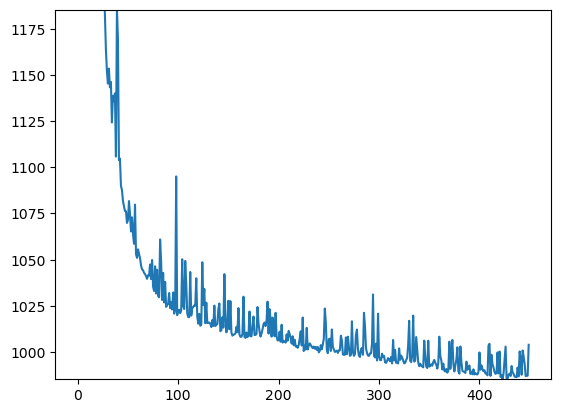

In [1357]:
import copy
import warnings
warnings.filterwarnings('ignore')


class EarlyStopping:
    def __init__(self, tolerance=5, min_delta=0):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:  
                self.early_stop = True

null_mse = 0
def validate(test_dataloader, model, verbose=False):
    global null_mse
    
    model.eval()
    with torch.no_grad():
        i = 0
        mse = 0
        mse_null = 0
        for x, y in test_dataloader:
            x = x.clone()
            y = y.clone()
            i += 1
            labels = 56
            # labels = 0
            # old_x = scaler_x.inverse_transform(x)
            # year = old_x[:, year_idx]
            # crime = old_x[:, idx]
            # crime = scaler_y.inverse_transform(y.reshape(-1,1))
            crime = y.detach().cpu().numpy() * 20000
            old_x = x
            x = x.to(device)
            pred = model(x)
            # print('pred', pred, 'y', y)
            pred = pred.detach().cpu().numpy()
            old_x = old_x.detach().cpu().numpy()
            # out2 = np.hstack((x[:,labels:], pred.reshape(-1,1)))
            out2 = scaler_x.inverse_transform(old_x)
            # pred = scaler_y.inverse_transform(pred.reshape(-1,1))
            pred = pred * 20000

            mse += np.sum((pred - crime) ** 2)
            mse_null += np.sum((out2[:, last_idx+labels] - crime) ** 2)

    if verbose:
        # print('mse', np.sqrt(mse/(batch_size*i)), end=' ')
        print('mse_null', np.sqrt(mse_null/(batch_size*i)), end=' ')
        null_mse = np.sqrt(mse_null/(batch_size*i))
    return np.sqrt(mse/(batch_size*i))

epochs = []
loss = []


fig, ax = plt.subplots()

stopping = EarlyStopping(tolerance=50, min_delta=100)
best_val = 1e9
best_model = None
last = 0
epoch = 0
while not stopping.early_stop:
    # print(f"Epoch {t+1}\n-------------------------------")
    model.train()
    train(train_dataloader, model, loss_fn, optimizer)

    test_val = validate(test_dataloader, model, True)
    train_val = validate(train_dataloader, model, False)
    print(f"test {test_val:.2f}, train {train_val:.2f}", end='\n')

    stopping(best_val, test_val)
    last = test_val

    if test_val < best_val:
        best_val = test_val
        best_model = copy.deepcopy(model)

    epochs.append(epoch)
    loss.append(test_val)
    epoch += 1
    if epoch % 10 == 0:
        ax.clear()
        ax.plot(epochs, loss)
        ax.axhline(y=null_mse, color='r')
        ax.set_ylim([best_val, best_val+200])
        fig.savefig('loss.png')


print(f"\nBest loss: {best_val:.2f}")
model = best_model

In [357]:
scaler.scale_
scaler.var_

m = scaler.mean_[idx]
s = scaler.scale_[idx]
m, s

y_m = scaler.mean_[year_idx]
s_m = scaler.scale_[year_idx]

In [192]:
x, y = next(iter(test_dataloader))
y.reshape(4, -1).shape

torch.Size([4, 1])

In [589]:
model.eval()
with torch.no_grad():
    i = 0
    target = 10
    mse = 0
    for x, y in test_dataloader:
        i += 1
        # if i > target:
        #     break

        out = np.hstack((x[:,56:], y.reshape(-1,1)))
        old_x = scaler.inverse_transform(out)
        # print(old_x)
        year = old_x[:, year_idx]
        crime = old_x[:, idx]
        # y = y * s + m

        # year = x[:,0] * s_m + y_m
        # print(encoder.inverse_transform(x[:,:56]))
        x = x.to(device)
        print(x)


        
        pred = model(x)
        pred = pred.detach().cpu().numpy()
        x = x.detach().cpu().numpy()
        out = np.hstack((x[:,56:], pred.reshape(-1,1)))
        out = scaler.inverse_transform(out)
        pred = out[:, idx]
        last = out2[:, last_idx]

        print(f'Predicted: "{pred}",\n Actual: "{crime}", Last: {last}')
        print(f'Year: "{year}"')

        mse += (pred - crime) ** 2

    print(np.sqrt(mse / i))

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 5.7707e-02, 0.0000e+00, 4.5917e-01,
         2.8705e-01, 6.5267e-01, 6.4742e-01, 6.5627e-01, 5.9151e-04, 1.6346e-03,
         1.5562e-03, 8.6199e-01, 1.8667e-01, 1.0964e-02, 8.0049e-02, 6.9897e-01,
         0.0000e+00, 1.0000e

In [1235]:
model = best_model


In [1358]:
from statsmodels.formula.api import ols
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error


model = best_model

def null_model(train_set, test_set):
    text = f"crime ~ last_crime"
    model = ols(text, data=train_set).fit()
    pred = model.predict(test_set)
    mse = mean_squared_error(test_set['crime'], pred)
    return np.sqrt(mse), model


def all_model(train_set, test_set):
    text = f'crime ~ C(lga) + last_crime + last_house + last_egm + last2_crime + last2_house + last3_house + last2_egm + last3_egm + last4_egm + last5_egm'
    model = ols(text, data=train_set).fit()
    pred = model.predict(test_set)
    mse = mean_squared_error(test_set['crime'], pred)

    return np.sqrt(mse), model

train_set = actual.loc[train_data.index]
test_set = actual.loc[test_data.index]
mse, null = null_model(train_set, test_set)
mse, cheating = all_model(train_set, test_set)
# print(mse)

mse = {
    'null': 0,
    'nn': 0,
    'cheating': 0
}

model.eval()
size = len(test_data.index)
for i in test_data.index:
    x = test_data.loc[i].copy()
    row = actual.loc[i]

    crime = actual.loc[i]['crime']
    features = x.drop(labels=['crime'], axis=0).values
    features = scaler_x.transform(features.reshape(1,-1))
    features = torch.tensor(features).to(device).to(torch.float)
    pred = model(features)

    pred = pred.detach().cpu().numpy()
    features = features.detach().cpu().numpy()
    # result = np.hstack((features[:,56:], pred.reshape(-1,1)))
    # result = scaler.inverse_transform(result)
    pred = (pred * 20000).item()
    # pred = result[:, idx].item()
    null_result = null.predict(actual.loc[[i]].drop(columns=['crime'], axis=1)).values[0]
    cheating_result =cheating.predict(actual.loc[[i]].drop(columns=['crime'], axis=1)).values[0] 
    print(f'LGA: {row["lga"]}, Year: {row["year"]}')
    print(f"NN: {pred:.2f}, NULL: {null_result:.2f}, Actual: {crime:.2f}")
    mse['null'] += (null_result-crime)**2
    mse['nn'] += (pred - crime)**2
    mse['cheating'] += (cheating_result - crime)**2

print('null', np.sqrt(mse['null']/size), 'nn', np.sqrt(mse['nn']/size), 'all', np.sqrt(mse['cheating']/size))

LGA: greatergeelong, Year: 2016
NN: 8594.08, NULL: 8944.57, Actual: 9586.31
LGA: moorabool, Year: 2016
NN: 6400.34, NULL: 6961.83, Actual: 7755.88
LGA: centralgoldfields, Year: 2016
NN: 10002.66, NULL: 9711.90, Actual: 11515.24
LGA: benalla, Year: 2016
NN: 9103.52, NULL: 8290.30, Actual: 11471.89
LGA: campaspe, Year: 2016
NN: 9429.74, NULL: 8230.76, Actual: 10240.72
LGA: wellington, Year: 2016
NN: 9611.36, NULL: 10111.51, Actual: 10905.12
LGA: wodonga, Year: 2016
NN: 9094.30, NULL: 9049.26, Actual: 8254.36
LGA: swanhill, Year: 2016
NN: 12061.31, NULL: 10748.74, Actual: 10643.19
LGA: southgippsland, Year: 2016
NN: 5292.40, NULL: 4886.74, Actual: 5161.05
LGA: macedonranges, Year: 2016
NN: 5213.97, NULL: 4809.35, Actual: 5172.70
LGA: horsham, Year: 2016
NN: 11937.96, NULL: 15029.51, Actual: 14202.37
LGA: boroondara, Year: 2016
NN: 4163.50, NULL: 4508.72, Actual: 4736.68
LGA: whitehorse, Year: 2016
NN: 5141.68, NULL: 5218.20, Actual: 4708.77
LGA: banyule, Year: 2016
NN: 7602.05, NULL: 7397

In [45]:
!export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:~/miniconda3/lib


In [68]:
from sklearn.svm import SVR , LinearSVR
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from statsmodels.formula.api import ols
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import make_pipeline
import warnings
import copy

warnings.filterwarnings("ignore")

class EarlyStopping:
    def __init__(self, tolerance=5, min_delta=0):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:  
                self.early_stop = True

 # Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

class NeuralNetwork(nn.Module):
    def __init__(self, train_x):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(train_x.shape[1], 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
def train_model(dataloader, model, loss_fn, optimizer):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

def test_model(dataloader, model, scaler):
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            pred = model(X)

            pred = scaler.inverse_transform(pred.detach().cpu().numpy().reshape(-1, 1))
            y = scaler.inverse_transform(y.reshape(-1, 1))
            test_loss += (pred - y) ** 2

    test_loss /= num_batches
    return test_loss.item()

state = 10000
torch.manual_seed(state)
torch.use_deterministic_algorithms(False)

def create_network(train_data, test_data):
    scaler_x = MinMaxScaler(feature_range=(0,1))
    scaler_y = MinMaxScaler(feature_range=(0,1))

    train_y = train_data['crime'].copy().values
    train_x = train_data.drop('crime', axis=1).copy().values
    # train_X, val_X, train_Y, val_Y = train_test_split(train_x, train_y, test_size=0.0, random_state=state)
    train_X = train_x
    train_Y = train_y
    
    test_y = test_data['crime'].copy().values
    test_x = test_data.drop('crime', axis=1).copy().values

    scaler_x.fit(train_X)
    scaler_y.fit(train_Y.reshape(-1, 1))

    train_X = scaler_x.transform(train_X)
    train_Y = scaler_y.transform(train_Y.reshape(-1, 1))

    # val_X = scaler_x.transform(val_X)
    # val_Y = scaler_y.transform(val_Y.reshape(-1, 1))

    test_y = scaler_y.transform(test_y.reshape(-1, 1))
    test_x = scaler_x.transform(test_x)

    batch_size = 1
    train = data_utils.TensorDataset(torch.Tensor(train_X), torch.Tensor(train_Y))
    test = data_utils.TensorDataset(torch.Tensor(test_x), torch.Tensor(test_y))
    # val = data_utils.TensorDataset(torch.Tensor(val_X), torch.Tensor(val_Y))
    train_dataloader = DataLoader(train, batch_size=batch_size, shuffle=True)
    # val_dataloader = DataLoader(val, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test, batch_size=batch_size, shuffle=True)
 

    model = NeuralNetwork(train_x).to(device)

    loss_fn = nn.HuberLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)

    stopping = EarlyStopping(tolerance=50, min_delta=200)
    best_val = 1e9
    best_model = None
    epoch = 0
    while not stopping.early_stop and epoch < 300:
        train_model(train_dataloader, model, loss_fn, optimizer)
        test_val = np.sqrt(test_model(test_dataloader, model, scaler_y))
        print(f"epoch {epoch}, val {test_val:7.2f}, best {best_val:7.2f}", end='\r')

        stopping(best_val, test_val)

        if test_val < best_val:
            best_val = test_val
            best_model = copy.deepcopy(model)
        epoch += 1

    print('', end='\r')
    return test_model(test_dataloader, model, scaler_y)


def null_model(train_set, test_set):
    text = f"crime ~ last_crime"
    model = ols(text, data=train_set).fit()
    pred = model.predict(test_set)
    mse = mean_squared_error(test_set['crime'], pred)
    return mse

def all_model(train_set, test_set):
    lgas = ' + '.join([f"lga{i}" for i in range(56)])
    text = f'crime ~ {lgas} + last_crime + last_house + last_egm + last2_crime + last2_house + last3_house + last2_egm + last3_egm + last4_egm + last5_egm'
    model = ols(text, data=train_set).fit()
    pred = model.predict(test_set)
    mse = mean_squared_error(test_set['crime'], pred)

    return mse


def svm_model(train_data, test_data):
    train_y = train_data['crime'].values
    train_x = train_data.drop('crime', axis=1).values
    test_y = test_data['crime'].values
    test_x = test_data.drop('crime', axis=1).values

    param_grid = {
        "svr__C": [1000000, 2000000, 10000000, 500000],
        "svr__epsilon": [0.1, 0.2, 0.3,10,20]
    }
    svr = make_pipeline(
        MinMaxScaler(feature_range=(0,1)), 
        SVR(cache_size=4000)
    )
  
    grid = GridSearchCV(estimator=svr, cv=5, param_grid=param_grid, n_jobs=18)
    grid.fit(train_x, train_y)
    pred = grid.predict(test_x)
    mse = mean_squared_error(pred, test_y)
    return mse

def tree_model(train_data, test_data):
    lgas = [f"lga{i}" for i in range(56)]
    kept = ['last_crime', 'last_house', 'last_egm', 'last2_crime', 'last2_house', 'last2_egm', 'last3_house', 'last3_egm']

    train_y = train_data['crime'].values
    old_train_x = train_data.drop('crime', axis=1).values

    test_y = test_data['crime'].values
    old_test_x = test_data.drop('crime', axis=1).values


    # pca = PCA(n_components=10)
    # pca.fit(old_train_x)
   

    train_x = train_data[lgas+kept].values
    test_x = test_data[lgas+kept].values
    # train_x = np.hstack((train_x, pca.transform(old_train_x)))
    # test_x = np.hstack((test_x, pca.transform(old_test_x)))

    param_grid = {
        'max_depth': [1,2,3,4,5],
        'n_estimators': [ 50, 100, 200, 300],
        'learning_rate': [0.1,0.15,0.2,0.25,0.3]
    }

    reg = GradientBoostingRegressor()
    grid = GridSearchCV(estimator=reg, cv=5, param_grid=param_grid, n_jobs=18)
    # grid = DecisionTreeRegressor(max_depth=5)
    # reg = AdaBoostRegressor(n_estimators=1000)
    grid.fit(train_x, train_y)
    return mean_squared_error(test_y, grid.predict(test_x))

 

n = 20
fold = KFold(n, shuffle=True, random_state=state,)

models = {
    'null': null_model,
    'all': all_model,
    'svm': svm_model,
    'network': create_network,
    # 'tree': tree_model,
}

total_mse = {k: 0 for k in models}
total = 0
for train, test in fold.split(new):
    train_set = new.iloc[train].copy()
    test_set = new.iloc[test].copy()

    total += 1
    print(f"progress {total / n:.2f}")
    
    for k, v in models.items():
        mse = v(train_set, test_set)
        total_mse[k] += mse
        print(f", model {k:10}, RMSE: {np.sqrt(total_mse[k]/total):6.2f}")




progress 0.05
, model null      , RMSE: 889.13
, model all       , RMSE: 898.98
, model svm       , RMSE: 601.18
, model network   , RMSE: 845.604.140.00
progress 0.10
, model null      , RMSE: 927.00
, model all       , RMSE: 929.40
, model svm       , RMSE: 777.29
, model network   , RMSE: 882.242.050.00
progress 0.15
, model null      , RMSE: 865.28
, model all       , RMSE: 913.05
, model svm       , RMSE: 733.39
, model network   , RMSE: 876.838.110.00
progress 0.20
, model null      , RMSE: 868.03
, model all       , RMSE: 868.89
, model svm       , RMSE: 738.79
, model network   , RMSE: 854.633.120.00
progress 0.25
, model null      , RMSE: 895.43
, model all       , RMSE: 841.94
, model svm       , RMSE: 690.98
, model network   , RMSE: 808.454.460.00
progress 0.30
, model null      , RMSE: 872.05
, model all       , RMSE: 816.44
, model svm       , RMSE: 664.21
, model network   , RMSE: 797.018.890.00
progress 0.35
, model null      , RMSE: 840.49
, model all       , RMSE: 775

In [36]:
print()
for k, v in total_mse.items():
    print(f"model {k:15}, RMSE: {np.sqrt(v/n):14.2f}")
    


model null           , RMSE:         858.29
model all            , RMSE:         759.71
model svm            , RMSE:         656.72
model network        , RMSE:         784.43


In [328]:
# PREDICTIONS

def build_features(data, target):
    actual = data.copy()

    # insert last year
    features = []

    for lga in actual['lga'].unique():
        last = data[(data['year'] == target-1) & (data['lga'] == lga)].copy()
        if last.shape[0] != 1:
            continue

        row = last.copy().iloc[0, :]
        distance = np.sqrt(last['locationx'] ** 2 + last['locationy'] ** 2)
        row['distance'] = distance.values[0]
        row['year'] = target
        row['lga'] = lga


        last_2 = data[(data['year'] == row['year']-2) & (data['lga'] == row['lga'])].copy()
        last_3 = data[(data['year'] == row['year']-3) & (data['lga'] == row['lga'])].copy()
        last_4 = data[(data['year'] == row['year']-4) & (data['lga'] == row['lga'])].copy()
        last_5 = data[(data['year'] == row['year']-5) & (data['lga'] == row['lga'])].copy()
        row['last_crime'] = last['crime'].values[0]
        row['last2_crime'] = last_2['crime'].values[0]
        row['last_house'] = last['medianhouseprice'].values[0]
        row['last2_house'] = last_2['medianhouseprice'].values[0]
        row['last3_house'] = last_3['medianhouseprice'].values[0]
        row['last_egm'] = last['egm'].values[0]
        row['last2_egm'] = last_2['egm'].values[0]
        row['last3_egm'] = last_3['egm'].values[0]
        row['last4_egm'] = last_4['egm'].values[0]
        row['last5_egm'] = last_5['egm'].values[0]

        features.append(row)

    actual = pd.concat(features, axis=1).T
    actual = actual.apply(pd.to_numeric, errors='ignore')
    actual = actual.dropna(axis=0).reset_index(drop=True).drop(columns=['offencecount', 'egm', 'medianhouseprice'], axis=1)

    encoder = OneHotEncoder()
    encoded = actual.copy()

    new_ = encoded.select_dtypes(include=[np.number])

    out = encoder.fit_transform(encoded[['lga']])
    lga = pd.DataFrame(out.toarray())
    lga.rename(columns=lambda c: f"lga{c}", inplace=True)
    new = pd.concat([lga, new_], axis=1)

    return encoder, new


def build_and_use_svm(train_data, test_data, encoder):
    train_y = train_data['crime'].values
    train_x = train_data.drop('crime', axis=1).values
    test_x = test_data.drop('crime', axis=1).values

    param_grid = {
        "svr__C": [1000000, 2000000, 10000000, 500000],
        "svr__epsilon": [0.1, 0.2, 0.3,10,20]
    }
    svr = make_pipeline(
        MinMaxScaler(feature_range=(0,1)), 
        SVR(cache_size=4000)
    )
  
    grid = GridSearchCV(estimator=svr, cv=5, param_grid=param_grid, n_jobs=18)
    grid.fit(train_x, train_y)
    pred = grid.predict(test_x)

    out = {
        'lga': [],
        'crime': []
    }
    for i in range(test_x.shape[0]):
        lga = encoder.inverse_transform(test_x[i, :56].reshape(1, -1))[0,0]
        out['lga'].append(lga)
        out['crime'].append(pred[i])

    return pd.concat((pd.DataFrame(out), test_data.drop(columns=['crime'] + [f"lga{i}" for i in range(56)], axis=1)), axis=1)

pred_encoder, pred_features = build_features(data, 2024)
result: pd.DataFrame = build_and_use_svm(new, pred_features, pred_encoder)
result.to_csv('pred.csv')
result

,lga,crime,year,traveltimetogpominutes,areakm2,ariamin,ariamax,ariaavg,commercialkm2,industrialkm2,...,last_crime,last2_crime,last_house,last2_house,last3_house,last_egm,last2_egm,last3_egm,last4_egm,last5_egm
0,whittlesea,4362.388889,2024,35.366070,937.879053,0.006308,0.058839,0.025918,0.003475,0.007859,...,4863.661646,4689.233060,8.029617e+05,8.240730e+05,8.056823e+05,1.474469e+08,1.049100e+08,72128889.57,9.106652e+07,1.207063e+08
1,northerngrampians,11419.017668,2024,172.320658,11420.312345,1.868060,2.633152,2.241487,0.000106,0.000389,...,10517.902844,9839.611383,3.821250e+05,4.037500e+05,3.232500e+05,1.109367e+07,7.816159e+06,5460348.53,7.004272e+06,9.200584e+06
2,greatergeelong,7050.211078,2024,62.298568,1399.303494,0.159625,0.230437,0.188364,0.002419,0.026589,...,7950.037374,7145.697051,8.317970e+05,8.977808e+05,7.944614e+05,1.355966e+08,1.055019e+08,70561866.77,8.913726e+07,1.203854e+08
3,colacotway,5762.459688,2024,155.599695,6949.122615,1.568191,2.174351,1.847313,0.000270,0.000522,...,5754.102209,5848.495398,6.159615e+05,5.847692e+05,5.223462e+05,1.102290e+07,9.067925e+06,5925575.86,8.316807e+06,1.075162e+07
4,moorabool,4967.234812,2024,67.836386,3529.342662,0.444782,0.956087,0.690579,0.000378,0.001475,...,5886.833576,4802.711126,7.191500e+05,7.470000e+05,6.758000e+05,1.450908e+07,1.214007e+07,7713038.67,9.631821e+06,1.234074e+07
5,centralgoldfields,5924.385829,2024,107.484869,3732.502132,0.828401,1.449899,1.082497,0.000246,0.002166,...,6768.508089,6198.095398,6.225000e+05,6.090714e+05,5.434286e+05,1.158900e+07,9.212945e+06,5732436.81,7.997285e+06,1.044870e+07
6,mitchell,6581.868005,2024,90.473714,9937.764782,0.983279,1.544353,1.221424,0.000213,0.000620,...,6923.713517,6465.215147,6.113684e+05,6.323158e+05,5.543421e+05,2.427246e+07,1.842390e+07,12006435.95,1.507287e+07,2.191991e+07
7,alpine,4443.456372,2024,262.158611,12672.409204,2.009198,3.766950,2.820244,0.000036,0.000190,...,4131.937459,3188.371735,6.613889e+05,6.653889e+05,5.272778e+05,3.082046e+06,2.636675e+06,1713340.14,1.892293e+06,2.304602e+06
8,benalla,8580.767142,2024,152.956477,9197.667462,1.480588,1.957789,1.697336,0.000415,0.001934,...,8138.300643,7046.601815,5.098182e+05,6.393636e+05,4.086818e+05,1.451648e+07,1.209234e+07,6976762.71,8.887679e+06,1.107790e+07
9,campaspe,9951.955147,2024,189.074534,5028.827790,1.531440,1.894523,1.690766,0.000698,0.001373,...,10015.490830,8440.652980,3.475417e+05,3.533750e+05,3.082917e+05,1.303303e+07,1.099017e+07,6719168.52,8.330467e+06,1.080534e+07


<Axes: xlabel='year'>

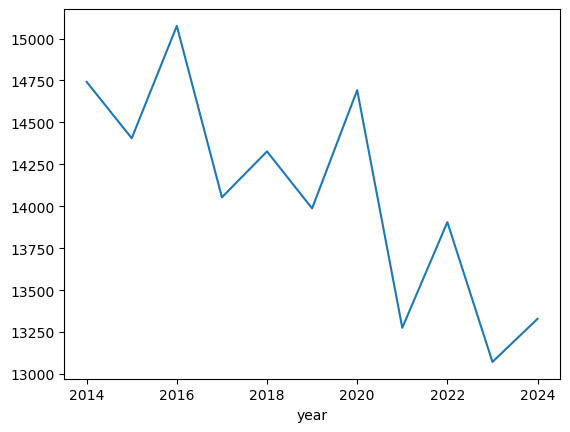

In [177]:
melbourne = pd.concat([data[data['lga'] == 'yarra'][['lga', 'year', 'crime']], result[result['lga'] == 'yarra']])
melbourne.set_index('year')['crime'].plot()


0     0.896935
1     1.085674
2     0.886815
3     1.001452
4     0.843787
5     0.875287
6     0.950627
7     1.075393
8     1.054368
9     0.993656
10    0.981928
11    1.009629
12    0.900660
13    0.972036
14    0.882947
15    1.020143
16    1.090265
17    0.972060
18    1.049292
19    1.059511
20    0.971307
21    1.282901
22    1.006297
23    0.941217
24    0.855233
25    1.028625
26    0.996522
27    0.937924
28    0.934504
29    0.928944
30    1.007180
31    0.984740
32    1.002530
33    0.967978
34    0.876433
35    1.031176
36    0.898701
37    1.053008
38    0.880950
39    0.867359
40    0.850056
41    0.808480
42    0.949706
43    1.013055
44    0.774128
45    0.937239
46    0.903531
47    0.927455
48    0.779565
49    0.913500
50    1.019657
51    0.977286
52    1.087243
53    0.941037
54    1.002936
55    0.913178
dtype: float64

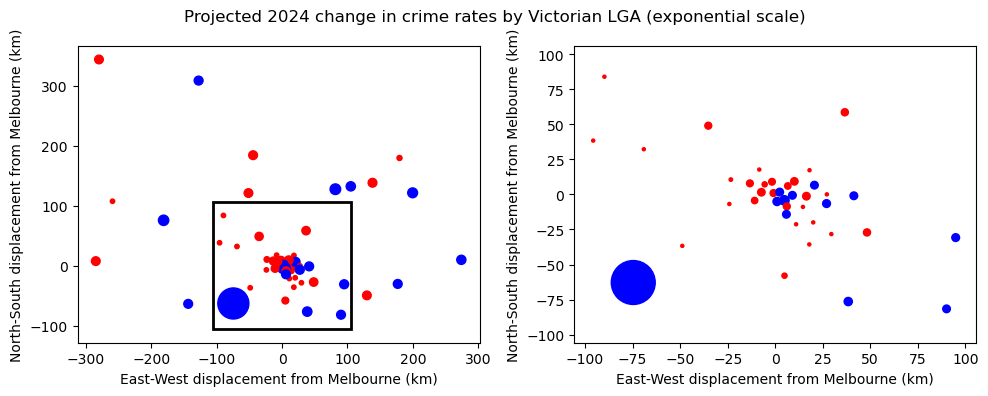

In [327]:
import matplotlib.patches as patches

def abs_log(xs):
    return np.sign(xs) * np.log(np.abs(xs))

fig, axes = plt.subplots(1,2, figsize=(10,4))
axes[0].scatter(
    result['locationx'], result['locationy'],
    s=np.clip(np.sinh(40*(result['crime']/result['last_crime']-1))+40, a_min=10, a_max=500),
      c=result['crime']/result['last_crime'] < 1,
      cmap='bwr')

axes[0].set_xlabel('East-West displacement from Melbourne (km)')
axes[0].set_ylabel('North-South displacement from Melbourne (km)')

limit = result[(result['locationx'].abs() < 100) & (result['locationy'].abs() < 100)]
axes[1].scatter(
    limit['locationx'], limit['locationy'],
    s=np.clip(np.sinh(40*(limit['crime']/limit['last_crime']-1))+30, a_min=5, a_max=1000),
      c=limit['crime']/limit['last_crime'] < 1,
      cmap='bwr'
)
lim = max(np.max(np.abs(limit['locationx'])), np.max(np.abs(limit['locationy'])))+10
rect = patches.Rectangle((-lim, -lim), 2*lim, 2*lim, linewidth=2, edgecolor='black', facecolor='none')
axes[0].add_patch(rect)

axes[1].set_xlim([-lim, lim])
axes[1].set_ylim([-lim, lim])
axes[1].set_xlabel('East-West displacement from Melbourne (km)')
axes[1].set_ylabel('North-South displacement from Melbourne (km)')
fig.suptitle('Projected 2024 change in crime rates by Victorian LGA (exponential scale)')
fig.tight_layout()